# Toy BBN Confidence Interval for $\Omega_b h^2$ with Profile Likelihood Test

## Preamble

In [1]:
%load_ext autoreload

In [3]:
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from cycler import cycler

import sys
sys.path.append('..')

from tqdm.notebook import tqdm
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, grad, value_and_grad,jit
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline

In [24]:
# Load plot settings

from plot_params import params
#pylab.rcParams.update(params)

#cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
from linx.background import BackgroundModel
from linx.nuclear import NuclearRates 
from linx.abundances import AbundanceModel
from linx.const import eta0

## Inference

This notebook demonstrates how to obtain confidence intervals on parameters such as $\Omega_b h^2$ using BBN data, by performing a profile likelihood test. As a toy example, we will only profile over two rates that are important for D/H prediction: $d(d,n)$ $^3\mathrm{He}$, and $d(d,p)t$. 

First, we compute the background quantities. 

In [6]:
bkg_model = BackgroundModel()

# Call the class. 
t_vec, a_vec, rho_g_vec, rho_nu_vec, rho_NP_vec, p_NP_vec, Neff_vec = bkg_model(jnp.asarray(0.))

`\         /´  ||||        ||||  |||||     ||||  ||||   ||||
 /\_______/\   ||||        ||||  |||||||   ||||   |||| ||||
 ) __` ´__ (   ||||        ||||  |||| |||| ||||    |||||||
/  `-|_|-´  \  ||||        ||||  ||||  |||| |||    ||||||| 
/   (_x_)   \  ||||||||||  ||||  ||||   |||||||   |||| ||||
  )  `-´  (    ||||||||||  ||||  ||||    ||||||  ||||   ||||
 
Compiling thermodynamics model...


Next, we define an abundance model. We'll pick the `key_PRIMAT_2023` nuclear network. 

In [7]:
abd_model = AbundanceModel(
    NuclearRates(nuclear_net='key_PRIMAT_2023')
)

We define the following BBN likelihood, based on Aver et al. and Cooke et al. for experimental measurements of $\text{Y}_\text{P}$ and D/H respectively: 
$$
    -2 \log \mathcal{L} = \left( \frac{\text{D/H}^\text{pred} - \text{D/H}^\text{obs}}{\sigma_{\text{D/H}^\text{obs}}} \right)^2 + \left( \frac{\text{Y}_\text{P}^\text{pred} - \text{Y}_\text{P}^\text{obs}}{\sigma_{\text{Y}_\text{P}^\text{obs}}} \right)^2
$$
We'll write a function for $-2 \log \mathcal{L}$, which we take to be a function of the parameter $q$ for each of the two rates, as well as $\Omega_b h^2$. Remember that the rate $r(T)$ as a function of temperature is given by
$$
     \log r (T) = \log \overline{r} (T) + q \sigma (T) \,,
$$
where $\overline{r}$ is the mean value, and $\sigma$ is the uncertainty associated with $\log r$. 

In [8]:
DH_obs_mean = 2.527e-5
DH_obs_sig  = 0.03e-5

YP_obs_mean = 0.2449
YP_obs_sig  = 0.004 

In [9]:
# Check which entry in nuclear_rates_q corresponds to d(d,n)3He and d(d,p)t
print(abd_model.nuclear_net.reactions_names)
# It's entry [2] and [3] 

def get_m2LL(eta_fac, q_ddHe3n, q_ddtp): 

    # Construct nuclear_rates_q. Use addition of tuples for concatenation. 
    nuclear_rates_q = jnp.array((0, 0) + (q_ddHe3n, q_ddtp) + (0, 0, 0, 0, 0, 0, 0, 0))

    sol = abd_model(
        rho_g_vec, rho_nu_vec, 
        rho_NP_vec, p_NP_vec,
        t_vec=t_vec, a_vec=a_vec, 
        eta_fac = jnp.asarray(eta_fac), 
        tau_n_fac = jnp.asarray(1.), 
        nuclear_rates_q = nuclear_rates_q
    )

    DH_pred = sol[2] / sol[1] 
    YP_pred = sol[5] * 4 

    return ((DH_pred - DH_obs_mean) / DH_obs_sig)**2 + ((YP_pred - YP_obs_mean) / YP_obs_sig)**2 

['npdg', 'dpHe3g', 'ddHe3n', 'ddtp', 'tpag', 'tdan', 'taLi7g', 'He3ntp', 'He3dap', 'He3aBe7g', 'Be7nLi7p', 'Li7paa']


We now define a vectorized version of `get_m2LL`. We want to vectorize over `eta_fac`, `q_ddHe3n` and `q_ddtp`, so this requires nested calls of `vmap`: the inside call vectorizes over `q_ddtp`, and the middle call vectorizes over `q_ddHe3n`, and last one over `eta_fac`. The final `jit` function compiles everything. The function `get_m2LL_v` outputs an array that has dimensions `eta_fac x q_ddHe3n x q_ddtp`. 

In [14]:
get_m2LL_v = jit(vmap(
    vmap(vmap(get_m2LL, in_axes=(None, None, 0)), in_axes=(None, 0, None)), 
    in_axes=(0, None, None)
))

Next, we define the values of `eta_fac`, `q_ddHe3n` and `q_ddtp` to scan over, and then obtain an array of $-2 \log \mathcal{L}$: 

In [15]:
eta_fac_ary = jnp.logspace(
    jnp.log10(5.6e-10), jnp.log10(6.4e-10), num=50
) / eta0
q_ddHe3n_ary = jnp.linspace(-5, 5, num=11)
q_ddtp_ary = jnp.linspace(-5, 5, num=21)

m2LL = get_m2LL_v(eta_fac_ary, q_ddHe3n_ary, q_ddtp_ary)

Now let's look at the profile likelihood ratio (or rather -2 times the log of it), and make a plot. 

In [26]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

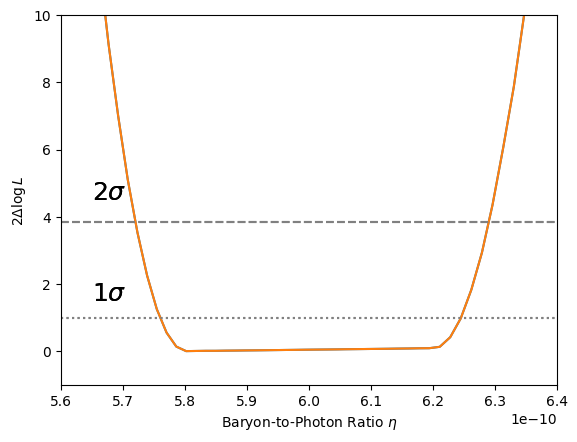

In [32]:
# Global minimum m2LL
m2LL_min = jnp.min(m2LL) 
# Profile m2LL: 
m2LL_profiled = jnp.min(jnp.min(m2LL, axis=2), axis=1)

plt.plot(eta_fac_ary * eta0, m2LL_profiled - m2LL_min)
plt.axhline(1., ls=':', color='gray')
plt.axhline(3.84, ls='--', color='gray')
plt.text(5.65e-10, 1.5, r'$1 \sigma$', fontsize=18)
plt.text(5.65e-10, 4.5, r'$2 \sigma$', fontsize=18)

plt.xlabel(r'Baryon-to-Photon Ratio $\eta$')
plt.ylabel(r'$2 \Delta \log L$')

plt.xlim(5.6e-10, 6.4e-10)
plt.ylim(-1, 10)
plt.show()

In [33]:
eta_fac_ary = jnp.logspace(
    jnp.log10(5.6e-8), jnp.log10(6.4e-8), num=50
) / eta0
q_ddHe3n_ary = jnp.linspace(-5, 5, num=11)
q_ddtp_ary = jnp.linspace(-5, 5, num=21)

m2LL = get_m2LL_v(eta_fac_ary, q_ddHe3n_ary, q_ddtp_ary)

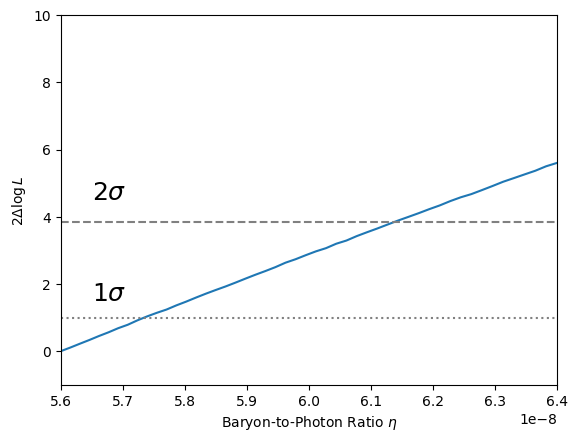

In [38]:
# Global minimum m2LL
m2LL_min = jnp.min(m2LL) 
# Profile m2LL: 
m2LL_profiled = jnp.min(jnp.min(m2LL, axis=2), axis=1)

plt.plot(eta_fac_ary * eta0, m2LL_profiled - m2LL_min)
plt.axhline(1., ls=':', color='gray')
plt.axhline(3.84, ls='--', color='gray')
plt.text(5.65e-8, 1.5, r'$1 \sigma$', fontsize=18)
plt.text(5.65e-8, 4.5, r'$2 \sigma$', fontsize=18)

plt.xlabel(r'Baryon-to-Photon Ratio $\eta$')
plt.ylabel(r'$2 \Delta \log L$')

plt.xlim(5.6e-8, 6.4e-8)
plt.ylim(-1, 10)
plt.show()